In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
import scipy.constants as sci_con
import multi_state_reaction as enzyme

In [2]:
# Define some things for simplicity
## Define some variables
inf = float('inf')
colors_hex_base = ["#008591", "#fff262", "#00f3ff", "#baaa00", "#356367", "#00141e"] # Custom Colors for figures

## Create color cycler for matplotlib and implement in rcParams.
custom_color_cycle = cycler(color=colors_hex_base)
plt.rcParams['axes.prop_cycle'] = custom_color_cycle
custom_palette = [item['color'] for item in custom_color_cycle]

## Define some helper functions:
def gaussian(x,mu,height,sigma):
    gauss = 1/sigma/(2*np.pi)**0.5*np.exp(-0.5*(x-mu)**2/sigma**2)
    return gauss/max(gauss)*height
def BW(x,mu,diff,steep):
    return diff/(1+np.exp(-1/steep*(x-mu)))
## Define a function to plot the potentials:
def plot_barriers(energies, barriersSM,barriersDM,name=0):
    x = np.linspace(0,18,1000)
    mu1 = 5
    mu2 = 13
    sigma = 1
    SM_red = gaussian(x,mu1,barriersSM[0][1]-(energies[0]+energies[1])/2,sigma)  +  BW(x,mu1,energies[1]-energies[0],1)  +  gaussian(x,mu2,barriersSM[2][1]-(energies[2]+energies[1])/2,sigma)  +  BW(x,mu2,energies[2]-energies[1],1)  +  energies[0]
    SM_ald = gaussian(x,mu1,barriersSM[0][1]-(energies[0]+energies[1])/2,sigma)  +  BW(x,mu1,energies[1]-energies[0],1)  +  gaussian(x,mu2,barriersSM[3][1]-(energies[3]+energies[1])/2,sigma)  +  BW(x,mu2,energies[3]-energies[1],1)  +  energies[0]
    DM_red = gaussian(x,mu1,barriersDM[0][1]-(energies[0]+energies[1])/2,sigma)  +  BW(x,mu1,energies[1]-energies[0],1)  +  gaussian(x,mu2,barriersDM[2][1]-(energies[2]+energies[1])/2,sigma)  +  BW(x,mu2,energies[2]-energies[1],1)  +  energies[0]
    DM_ald = gaussian(x,mu1,barriersDM[0][1]-(energies[0]+energies[1])/2,sigma)  +  BW(x,mu1,energies[1]-energies[0],1)  +  gaussian(x,mu2,barriersDM[3][1]-(energies[3]+energies[1])/2,sigma)  +  BW(x,mu2,energies[3]-energies[1],1)  +  energies[0]

    x = np.linspace(0,1,1000)
    fig = plt.figure(figsize=(14,7), dpi = 320)
    ax = fig.add_subplot(111)
    
    ax.plot(x,SM_red,label="SM reduction", color = "#baaa00")
    ax.plot(x+0.01,DM_red,label="DM reduction", color = "#fff262")
    ax.plot(x+0.02,SM_ald,label="SM aldol", color = "#00f3ff")
    ax.plot(x+0.03,DM_ald,label="DM aldol", color = "#008591")
    
    ax.legend(loc="upper right", fontsize = 13)
    ax.set_yticks([17.5,20.0,22.5,25.0,27.5,30.0,32.5,35.0,37.5])
    ax.set_xticks(np.arange(0,1,0.1))#, minor=True)
    ax.set_yticks(np.arange(17.5,37.5,0.5), minor=True)
    ax.set_yticklabels([17.5,20.0,22.5,25.0,27.5,30.0,32.5,35.0,37.5])
    ax.grid(True, axis='both',lw=1.5)
    ax.grid(True, axis='both', which='minor')
    ax.set_ylabel("Free Energy", fontsize = 13, fontname = "ARIAL", fontweight = "bold")
    ax.set_xlabel("Reaction Coordinate", fontsize = 13, fontname = "ARIAL", fontweight = "bold")
    ax.set_xlim(0.03,1)
    ax.set_ylim(17,38)
    if name!=0:
        plt.savefig(name, bbox_inches='tight')
    plt.show()

## The model
The code creates a discrete Markov model and performs forward integration. The transition rates are based on Arrhenius law. Mathematically we denote that by a vector $x_i$ which is $N$-dimensional, $N$ being the number of states. The transition matrix $m_{ij}$ is given by the Arrhenius law with a linear factor considering the concentration of the catalyst as this model was made for enzymes. Furthermore a parameter $k_0$ is introduced similar to the geometric factor in Polansky-Eyring theory.

$$m_{ij} = c_\text{kat}k_0\left\{\begin{array}{ll} \mathrm{exp}\left(-\frac{\Delta F_{j\rightarrow i}}{k_BT}\right), & \text{if}\ \ i\neq j\\ \sum_j\mathrm{exp}\left(-\frac{\Delta F_{i\rightarrow j}}{k_BT}\right), & \text{if}\ \ i= j \end{array}\right.$$

With $\Delta F_{i\rightarrow j}$ the height of the barrier from state $i$ to reach state $j$ is meant. From this point it is straightforward to solve the equations.

$$\begin{align}
    \frac{\partial x_i}{\partial t} = \sum_im_{ij}x_j
\end{align}$$

The absolute Free Energies of the states should be given as a vector, i.e.
$$F_S = \text{np.array}([F_1, F_2, ...])$$
The absolute Free Energies of the barriers should be given as a matrix, i.e.
$$F_B = \text{np.array}(\begin{array}{llll}[0,      & F_{12}, & ... & ]\\
                                           [F_{12}, & 0,      & ... & ]\\
                                           [.       & .,      & 0,\ \ ... & ])\end{array}$$

## An example model
I created this notebook when I was doing engineering on an enzyme. The original Enzyme catalyses a Reduction in a two step mechanism. We introduced a mutation to change the second step to perform an Aldol reaction. Now the mutant performs both reactions. This can be described by a 4-state model.

![Markov Model](state_model.png)

In [3]:
labels = ["Edukts", "Intermediate", "Reduction Product", "Aldol Product"]

We can write the set of differential equations in Matrix Form.
$$\begin{align}
\label{eq:markov}
    \frac{\partial}{\partial t}\left(\begin{array}{c}
        E \\
        I \\
        R \\
        A
    \end{array}\right) = k\left(\begin{array}{cccc}
        -e^{-\Delta F_{I\rightarrow E}} & e^{-\Delta F_{I\rightarrow E}} & 0 & 0\\
        e^{-\Delta F_{E\rightarrow I}} & -\left[e^{-\Delta F_{I\rightarrow E}} + e^{-\Delta F_{I\rightarrow R}} + e^{-\Delta F_{I\rightarrow A}}\right] & e^{-\Delta F_{R\rightarrow I}} & e^{-\Delta F_{A\rightarrow I}} \\
        0 & e^{-\Delta F_{I\rightarrow R}} & -e^{-\Delta F_{R\rightarrow I}} & 0 \\
        0 & e^{-\Delta F_{I\rightarrow A}} & 0 & -e^{-\Delta F_{A\rightarrow I}} 
        \end{array}\right)\left(\begin{array}{c}
        E \\
        I \\
        R \\
        A
    \end{array}\right)
\end{align}$$

In this model we consider both pathways in concurence, we expect the Reduction to form the thermodynamic product (lower in Free Energy), and the Aldol reaction the kinetic product (higher in Free Energy, but lower Free Energy barrier). We furthermore expect the first step (Edukt to Intermediate) to have a significantly higher barrier than the second step and therefore being rate determining for the system.

![Markov Model](barriers1_SMonly.png)

We save an example for these values in two numpy arrays as described in the introduction of the model.

In [4]:
free_energies = [22,25,18,19]
SM_transition_free_energies = [[inf, 35,inf,inf],
                               [ 35,inf, 34, 33],
                               [inf, 34,inf,inf],
                               [inf, 33,inf,inf]]

We identified a further mutation in the enzyme that seems to change the Free Energy landscape. We now differentiate between the onefold mutated enzyme (SM) and twofold mutated enzyme (DM). We expect the double mutant to go slower in total, therefore, having an even higher first barrier, but the Aldol reaction having a lower barrier.

![Markov Model](barriers1_4.png)

We now give an array for the transition barriers as expected for the double mutant and than continue creating the objects for each mutant with two different concentration and simulating them forward in time.

In [5]:
DM_transition_free_energies = [[inf, 37,inf,inf],
                               [ 37,inf, 34, 32],
                               [inf, 34,inf,inf],
                               [inf, 32,inf,inf]]
initial_conc = [1,0,0,0]

In [6]:
SM_L = enzyme.model(initial_conc,free_energies,SM_transition_free_energies,enzyme_conc = 0.00002, labels=labels)
SM_L.forward(40000)
SM_H = enzyme.model(initial_conc,free_energies,SM_transition_free_energies,labels=labels)
SM_H.forward(40000)

In [7]:
DM_L = enzyme.model(initial_conc,free_energies,DM_transition_free_energies,enzyme_conc = 0.00002, labels=labels)
DM_L.forward(40000)
DM_H = enzyme.model(initial_conc,free_energies,DM_transition_free_energies, labels=labels)
DM_H.forward(40000)

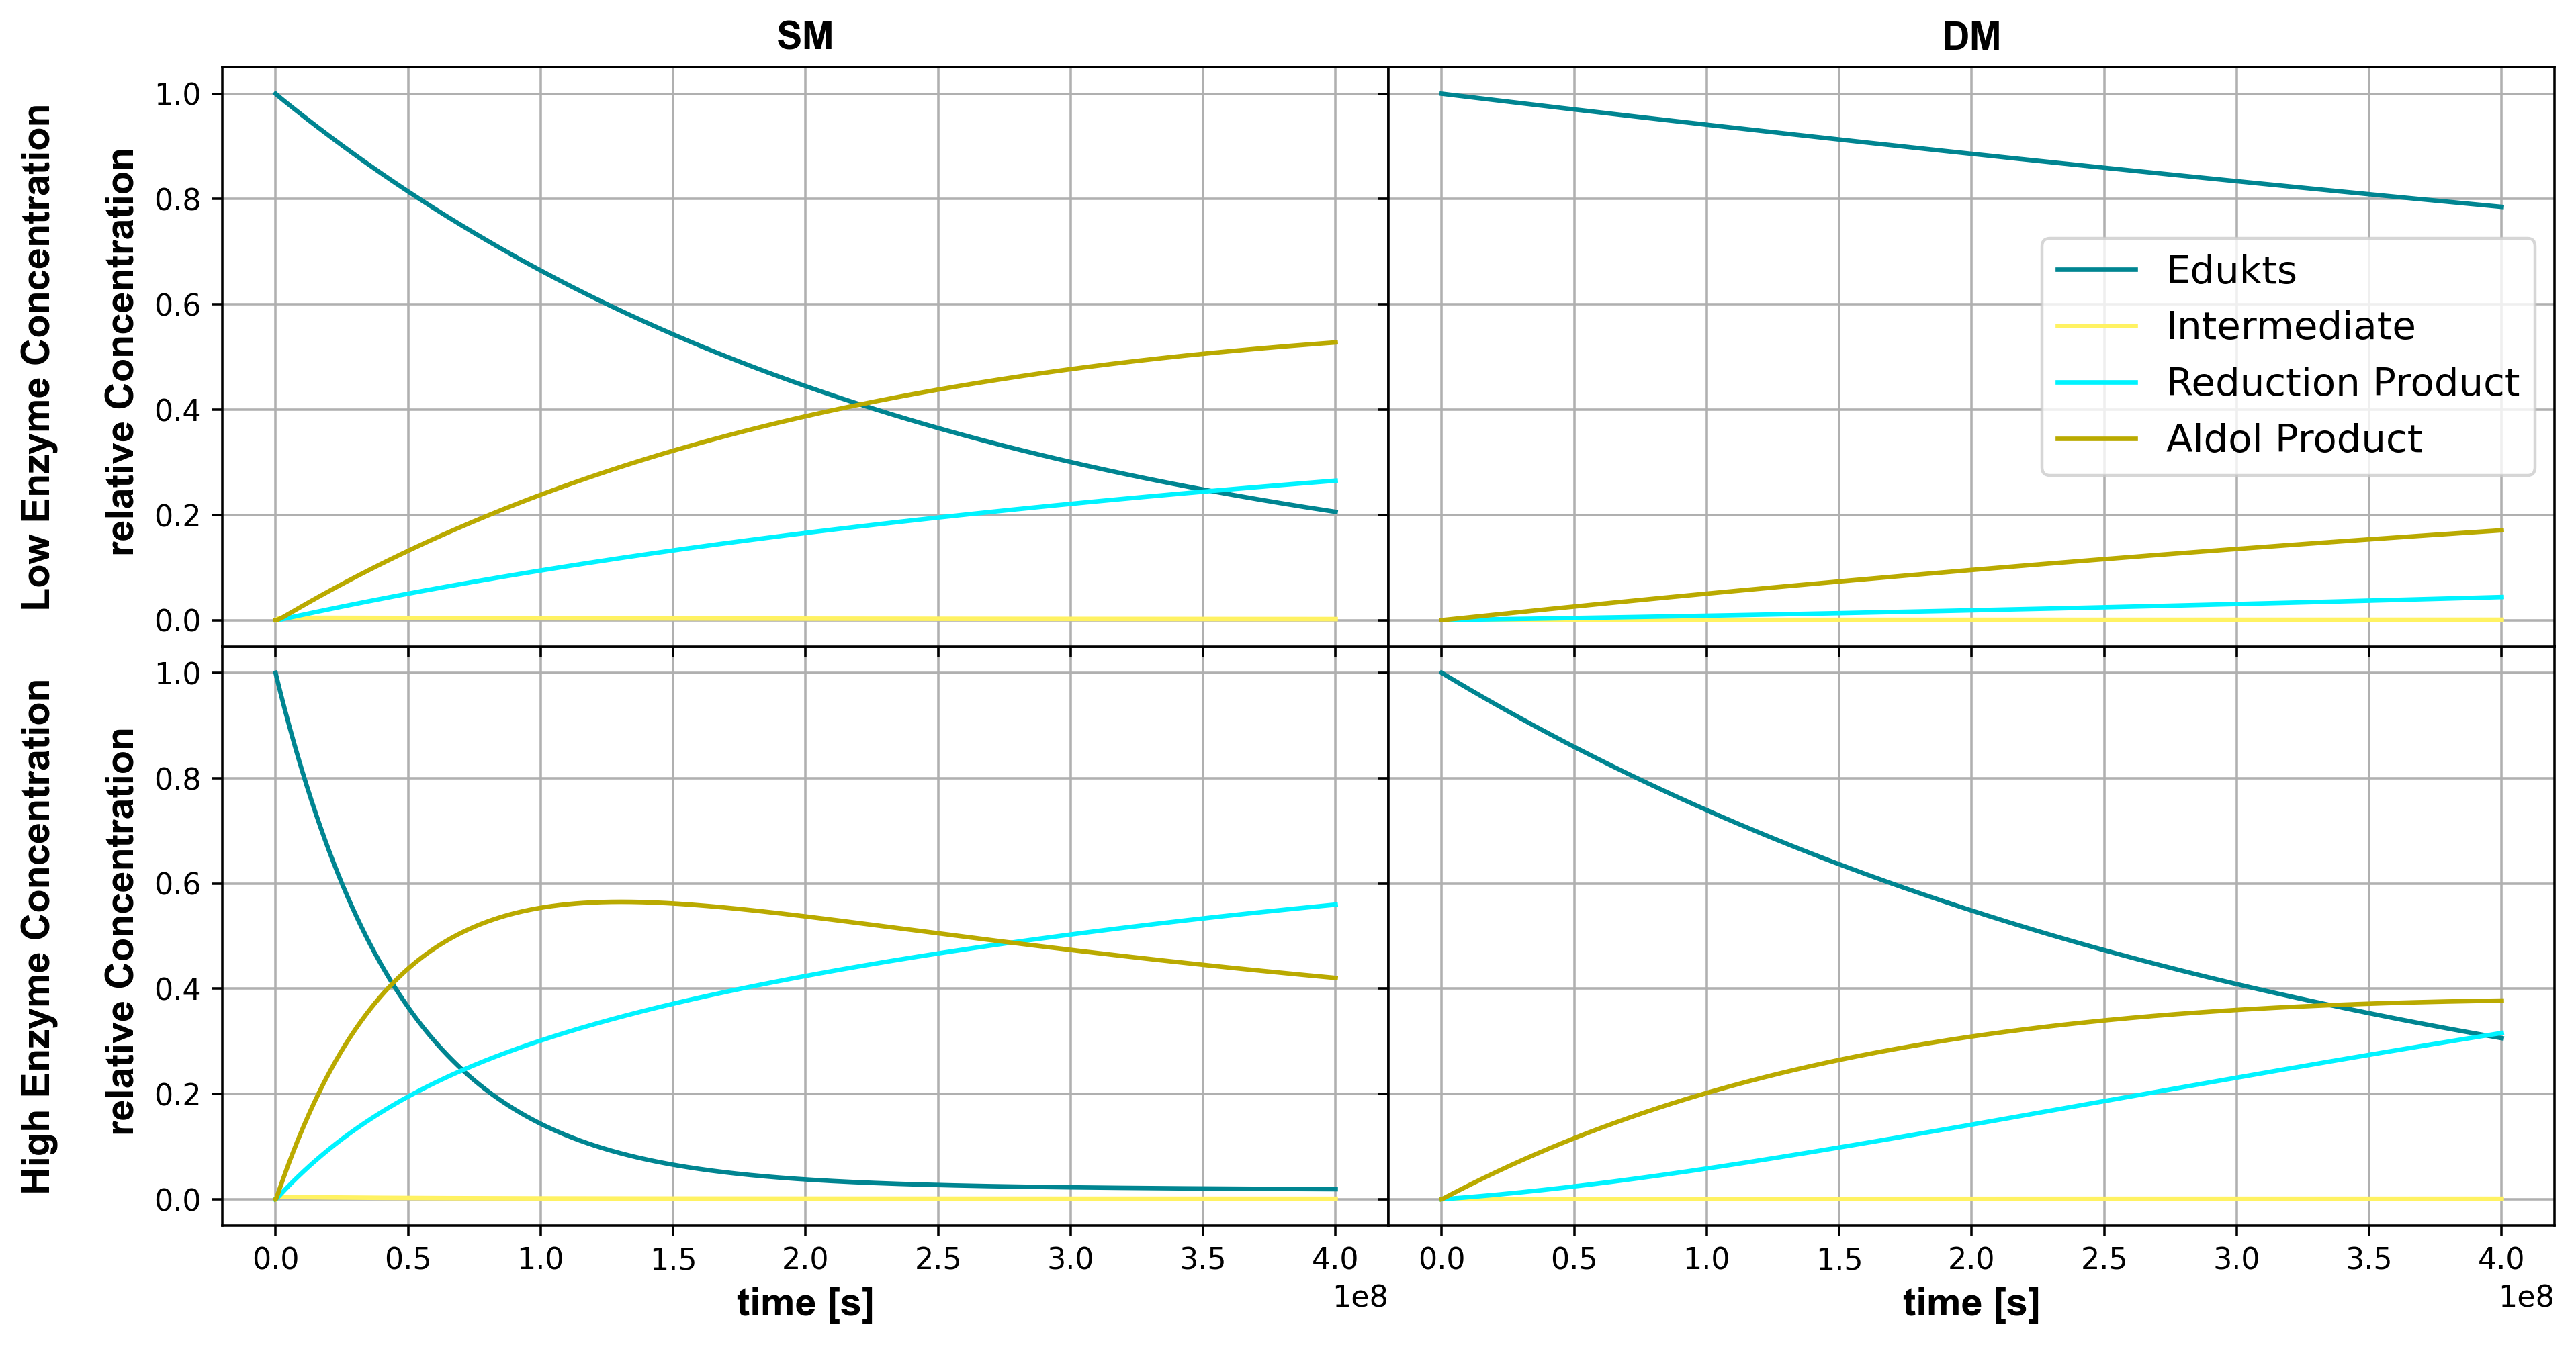

In [8]:
fig = plt.figure(figsize=(14,7), dpi = 320)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
SM_L.plot(ax1, title = "SM", xlabel = "none", ylabel = "Low Enzyme Concentration\n \n relative Concentration", grid="both", fontsize = 13, fontname = "ARIAL", fontweight = "bold")
DM_L.plot(ax2, title = "DM", xlabel = "none", ylabel = "none", legend = "right", grid="both", fontsize = 13, fontname = "ARIAL", fontweight = "bold")
SM_H.plot(ax3, ylabel = "High Enzyme Concentration\n \n relative Concentration", grid="both", fontsize = 13, fontname = "ARIAL", fontweight = "bold")
DM_H.plot(ax4, ylabel = "none", grid="both", fontsize = 13, fontname = "ARIAL", fontweight = "bold")
ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax4.set_yticklabels([])

plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("markov1.png", bbox_inches='tight')
plt.show()